In [ ]:
# Importing libraries
library(dplyr)
library(ggplot2)
library(readr)
library(DBI)
library(lubridate)

In [ ]:
# Creation of database connection
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = "Northwind",
    host = Sys.getenv("PG_HOST"),
    user = Sys.getenv("PG_USER"),
    password = Sys.getenv("PG_PASSWORD")
)

In [ ]:
# print a tibble of all tables in database 
tables <- tibble(dbListTables(con))
tables

dbListTables(con)
<chr>
categories
customer_customer_demo
customer_demographics
customers
employee_territories
employees
order_details
orders
products


In [ ]:
#use the dbgetquery function to extract columns from database to create dataset
df <- dbGetQuery(
    con,
    "
    SELECT
      o.order_date,
      EXTRACT(YEAR FROM o.order_date) AS year,
      TO_CHAR(order_date, 'Month') AS month,
      p.product_name, 
      c.category_name,
      od.unit_price, 
      od.quantity AS order_quantity
    FROM order_details as od
    INNER JOIN products as p
    USING(product_id)
    INNER JOIN categories as c
    USING(category_id)
    INNER JOIN orders as o
    USING(order_id);  
    "
)

In [ ]:
#view structure of dataset
glimpse(df)

Rows: 2,155
Columns: 7
$ order_date     <date> 1996-07-04, 1996-07-04, 1996-07-04, 1996-07-05, 1996-0…
$ year           <dbl> 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1…
$ month          <chr> "July     ", "July     ", "July     ", "July     ", "Ju…
$ product_name   <chr> "Queso Cabrales", "Singaporean Hokkien Fried Mee", "Moz…
$ category_name  <chr> "Dairy Products", "Grains/Cereals", "Dairy Products", "…
$ unit_price     <dbl> 14.0, 9.8, 34.8, 18.6, 42.4, 7.7, 42.4, 16.8, 16.8, 15.…
$ order_quantity <int> 12, 10, 5, 9, 40, 10, 35, 15, 6, 15, 20, 40, 25, 40, 20…


In [ ]:
#inspect for missing values
sum(is.na(df))

[1] 0

In [ ]:
#first 5 samples
head(df)

,order_date,year,month,product_name,category_name,unit_price,order_quantity
,<date>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>
1,1996-07-04,1996,July,Queso Cabrales,Dairy Products,14.0,12
2,1996-07-04,1996,July,Singaporean Hokkien Fried Mee,Grains/Cereals,9.8,10
3,1996-07-04,1996,July,Mozzarella di Giovanni,Dairy Products,34.8,5
4,1996-07-05,1996,July,Tofu,Produce,18.6,9
5,1996-07-05,1996,July,Manjimup Dried Apples,Produce,42.4,40
6,1996-07-08,1996,July,Jack's New England Clam Chowder,Seafood,7.7,10


# 📦 What are the best-selling products and categories?

In [ ]:
# prints out the top 20 performing products by revenue in descending order
best_prod_performance <- df %>%
group_by(product_name, category_name)%>%
summarise(total_revenue = sum(unit_price * order_quantity, na.rm = TRUE), .groups = 'drop_last')%>% 
ungroup()%>%
arrange(desc(total_revenue))

head(best_prod_performance, 20)

product_name,category_name,total_revenue
<chr>,<chr>,<dbl>
Côte de Blaye,Beverages,149984.2
Thüringer Rostbratwurst,Meat/Poultry,87736.4
Raclette Courdavault,Dairy Products,76296.0
Camembert Pierrot,Dairy Products,50286.0
Tarte au sucre,Confections,49827.9
Gnocchi di nonna Alice,Grains/Cereals,45121.2
Manjimup Dried Apples,Produce,44742.6
Alice Mutton,Meat/Poultry,35482.2
Carnarvon Tigers,Seafood,31987.5


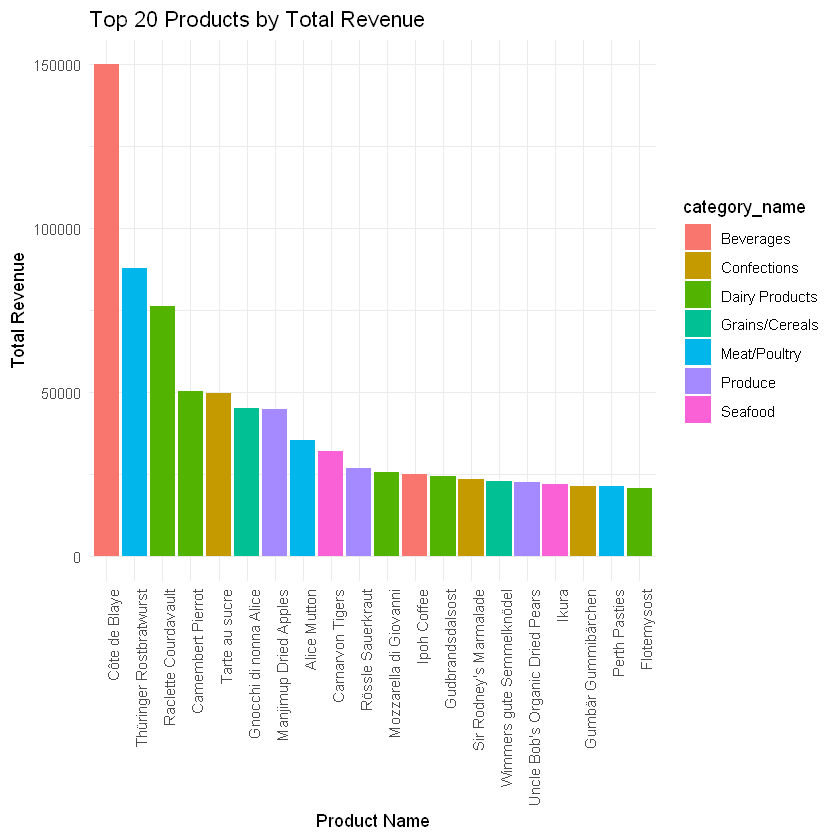

In [ ]:
# prints out barplot visualizaiton of the top 20 performing products by revenue in descending order
ggplot(head(best_prod_performance, 20), aes(x = reorder(product_name, -total_revenue), y = total_revenue)) +
geom_col(aes(fill = category_name)) +
labs(
    title = "Top 20 Products by Total Revenue",
    x = "Product Name",
    y = "Total Revenue"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1) # Rotate labels if they overlap
  )

In [ ]:
# prints out the top performing category name by revenue in descending order
best_cat_performance <- df %>%
group_by(category_name)%>%
summarise(total_revenue = sum(unit_price * order_quantity, na.rm = TRUE), .groups = 'drop_last')%>% 
ungroup()%>%
arrange(desc(total_revenue))

best_cat_performance

category_name,total_revenue
<chr>,<dbl>
Beverages,286527.0
Dairy Products,251330.5
Meat/Poultry,178188.8
Confections,177099.1
Seafood,141623.1
Condiments,113694.8
Produce,105268.6
Grains/Cereals,100726.8


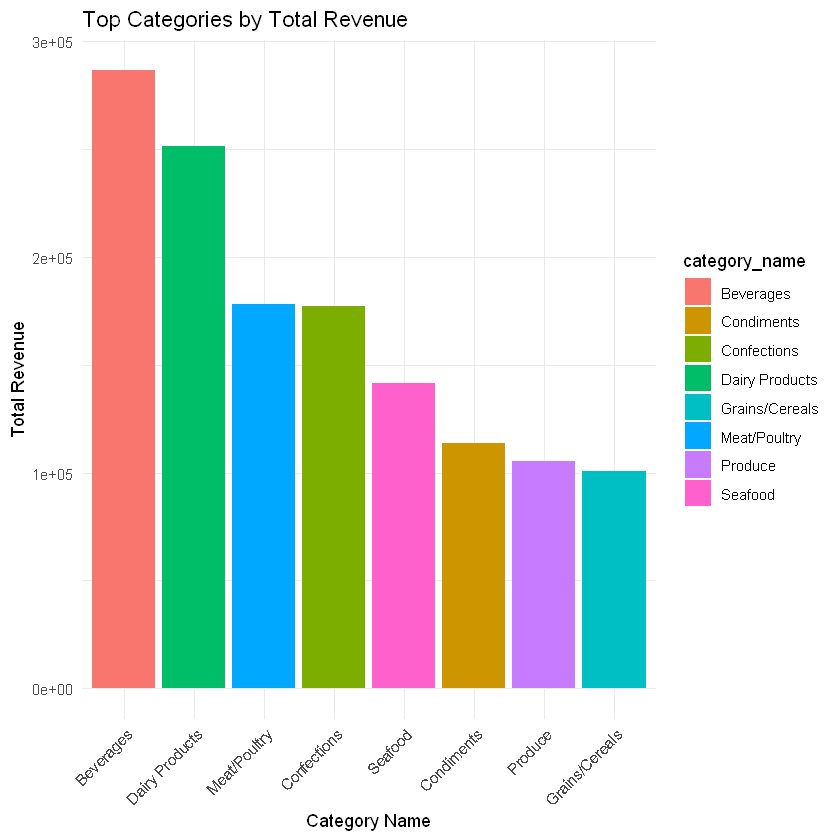

In [ ]:
# prints out barplot visualizaiton of the top performing category by revenue in descending order
ggplot(best_cat_performance, aes(reorder(category_name, -total_revenue), y = total_revenue)) +
geom_col(aes(fill = category_name)) +
labs(
    title = "Top Categories by Total Revenue",
    x = "Category Name",
    y = "Total Revenue"
) +
 theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1) # Rotate labels if they overlap
  )

# 🕒 Are there any seasonal trends in sales?

In [ ]:
# checks for possibble seasonal trends in sales by month 
best_month_performance <- df%>%
group_by(month)%>%
summarise(total_revenue = sum(unit_price * order_quantity, na.rm = TRUE), .groups = 'drop_last')%>% 
ungroup()%>%
arrange(desc(total_revenue))

best_month_performance

month,total_revenue
<chr>,<dbl>
April,190329.95
January,167547.52
March,149805.35
February,145769.15
December,128429.66
October,111532.10
November,95617.36
September,87369.02
July,85657.03


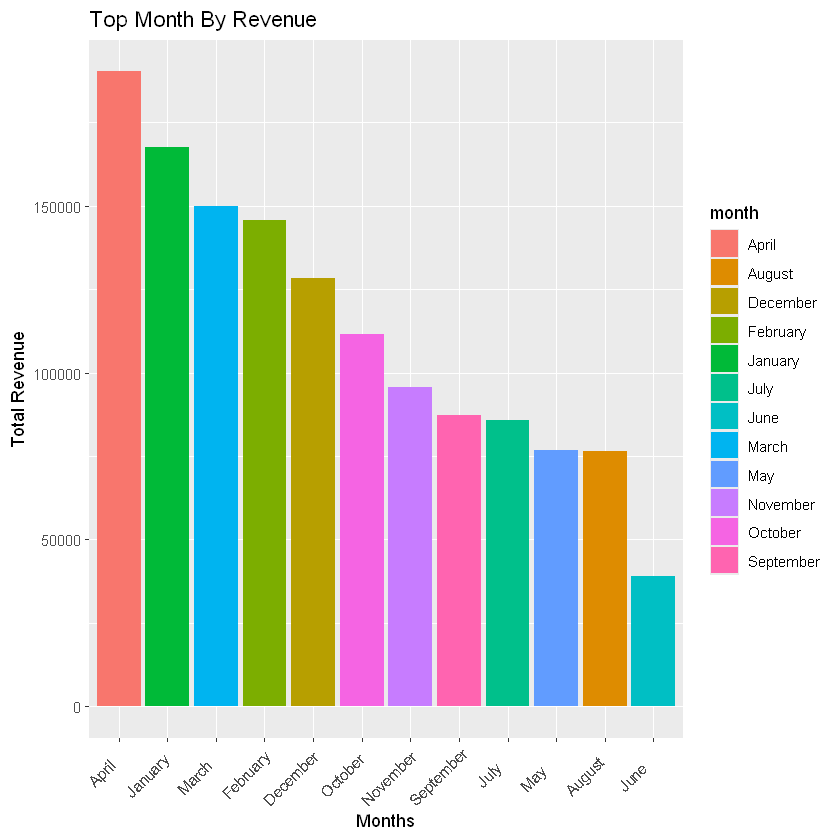

In [ ]:
# prints barplot visualization for seasonal trends by month
ggplot(best_month_performance, aes(x = reorder(month, -total_revenue), y = total_revenue)) +
geom_col(aes(fill = month)) +
labs(
    title = "Top Month By Revenue",
    x = "Months",
    y = "Total Revenue"
    ) +
theme(
    axis.text.x = element_text(angle = 45, hjust = 1) # Rotate labels if they overlap
  )

In [ ]:
# checks for possibble seasonal trends in sales by year
best_year_performance <- df%>%
group_by(year)%>%
summarise(total_revenue = sum(unit_price * order_quantity, na.rm = TRUE), .groups = 'drop_last')%>% 
ungroup()%>%
arrange(desc(total_revenue))

best_year_performance

year,total_revenue
<dbl>,<dbl>
1997,658388.8
1998,469771.3
1996,226298.5


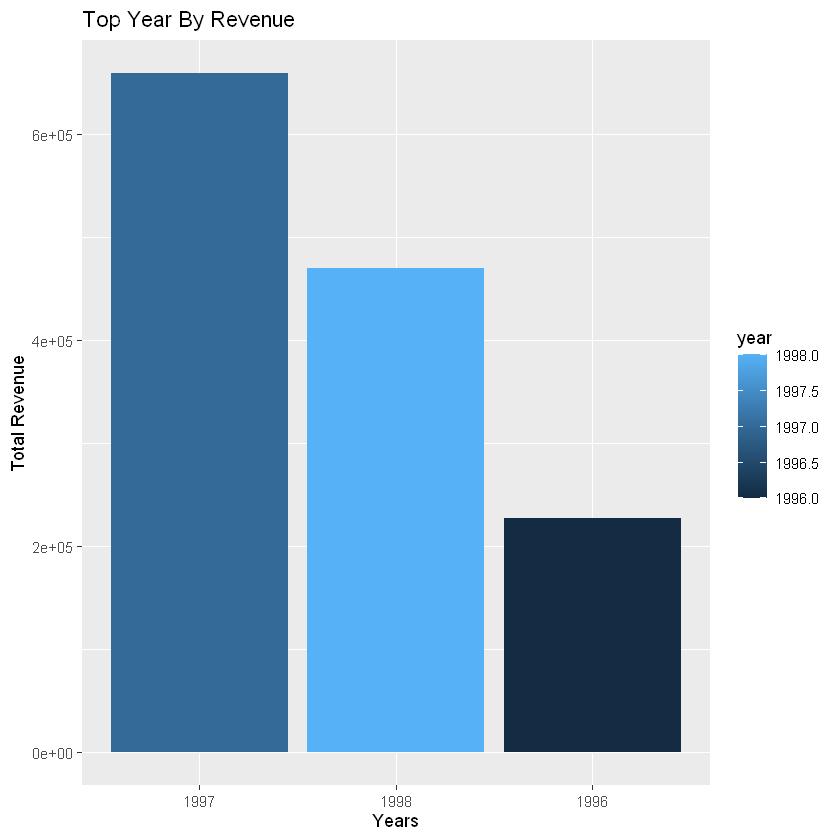

In [ ]:
# prints barplot visualization for seasonal trends by year
ggplot(best_year_performance, aes(x = reorder(year, -total_revenue), y = total_revenue)) +
geom_col(aes(fill = year)) +
labs(
    title = "Top Year By Revenue",
    x = "Years",
    y = "Total Revenue"
    ) 

In [ ]:
# checks for possibble seasonal trends in sales by months per year 
best_year_month <- df%>%
group_by(year, month)%>%
summarise(total_revenue = sum(unit_price * order_quantity, na.rm = TRUE), .groups = 'drop_last')%>% 
ungroup()%>%
arrange(year, desc(total_revenue))

best_year_month

year,month,total_revenue
<dbl>,<chr>,<dbl>
1996,December,50953.40
1996,November,49704.00
1996,October,41203.60
1996,July,30192.10
1996,September,27636.00
1996,August,26609.40
1997,December,77476.26
1997,October,70328.50
1997,January,66692.80


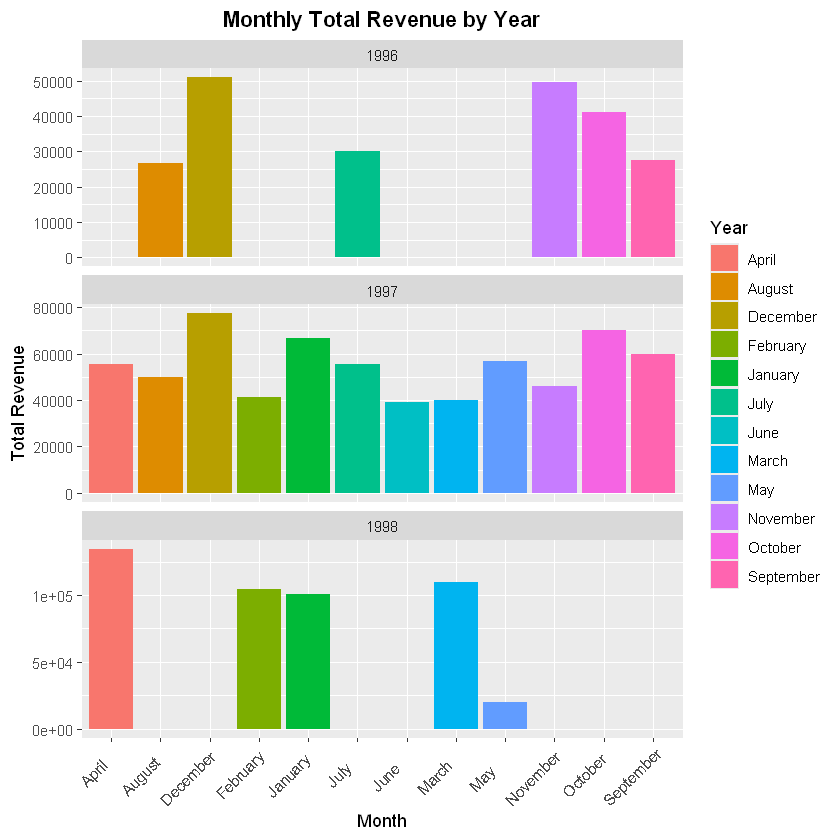

In [ ]:
# prints barplot visualization for seasonal trends by months per year 
ggplot(best_year_month, aes(x = month, y = total_revenue, fill = factor(year))) +
  geom_col(aes(fill = month)) + 
  facet_wrap(~ year, scales = "free_y", ncol = 1) + 
  labs(
    title = "Monthly Total Revenue by Year",
    x = "Month",
    y = "Total Revenue",
    fill = "Year"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

In [ ]:
# checks for possibble seasonal trends in sales by category per year
best_cat_year <- df%>%
group_by(year, category_name)%>%
summarise(total_revenue = sum(unit_price * order_quantity, na.rm = TRUE), .groups = 'drop_last')%>% 
ungroup()%>%
arrange(year, desc(total_revenue))

best_cat_year

year,category_name,total_revenue
<dbl>,<chr>,<dbl>
1996,Beverages,53879.20
1996,Dairy Products,44615.80
1996,Confections,31511.60
1996,Meat/Poultry,30292.20
1996,Seafood,21589.60
1996,Condiments,19458.30
1996,Produce,15134.20
1996,Grains/Cereals,9817.60
1997,Dairy Products,123910.80


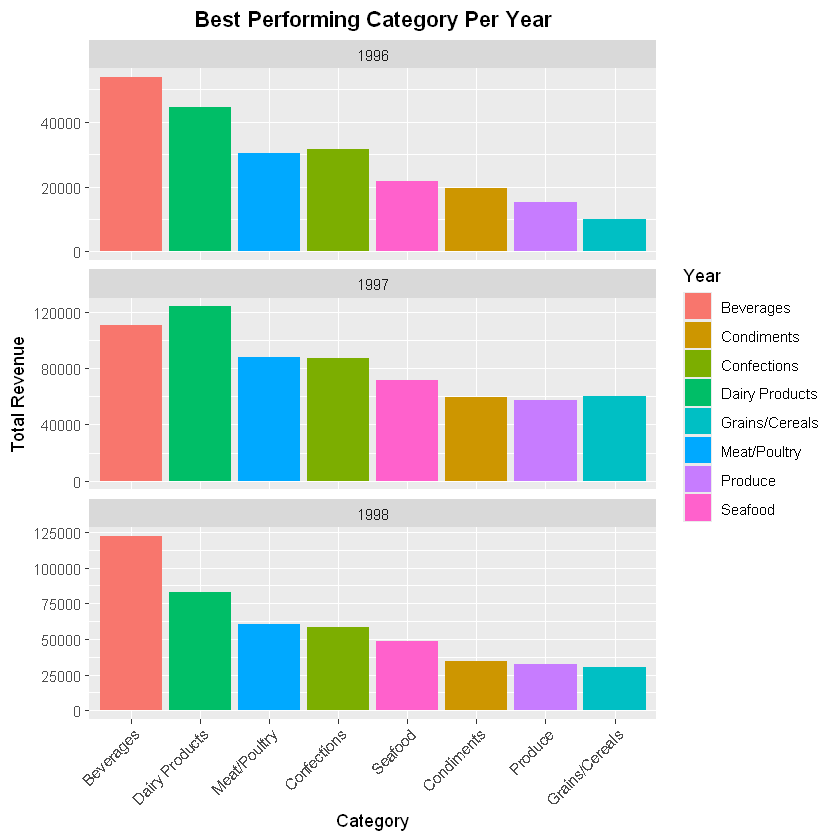

In [ ]:
# prints barplot visualization for seasonal trends by category per year 
ggplot(best_cat_year, aes(x = reorder(category_name, -total_revenue), y = total_revenue, fill = factor(year))) +
  geom_col(aes(fill = category_name)) + 
  facet_wrap(~ year, scales = "free_y", ncol = 1) + 
  labs(
    title = "Best Performing Category Per Year",
    x = "Category",
    y = "Total Revenue",
    fill = "Year"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

In [ ]:
# checks for possibble seasonal trends in sales by products per year 
best_prod_year <- df %>%
  group_by(year, product_name) %>% 
  summarise(total_revenue = sum(unit_price * order_quantity, na.rm = TRUE), .groups = 'drop_last') %>%
  slice_max(order_by = total_revenue, n = 5) %>%
  ungroup() %>% 
  arrange(year, desc(total_revenue)) 

best_prod_year

year,product_name,total_revenue
<dbl>,<chr>,<dbl>
1996,Côte de Blaye,29512.00
1996,Thüringer Rostbratwurst,12177.00
1996,Raclette Courdavault,10164.00
1996,Camembert Pierrot,10064.00
1996,Tarte au sucre,9850.00
1997,Côte de Blaye,51962.20
1997,Raclette Courdavault,37917.00
1997,Thüringer Rostbratwurst,36194.18
1997,Gnocchi di nonna Alice,34754.80


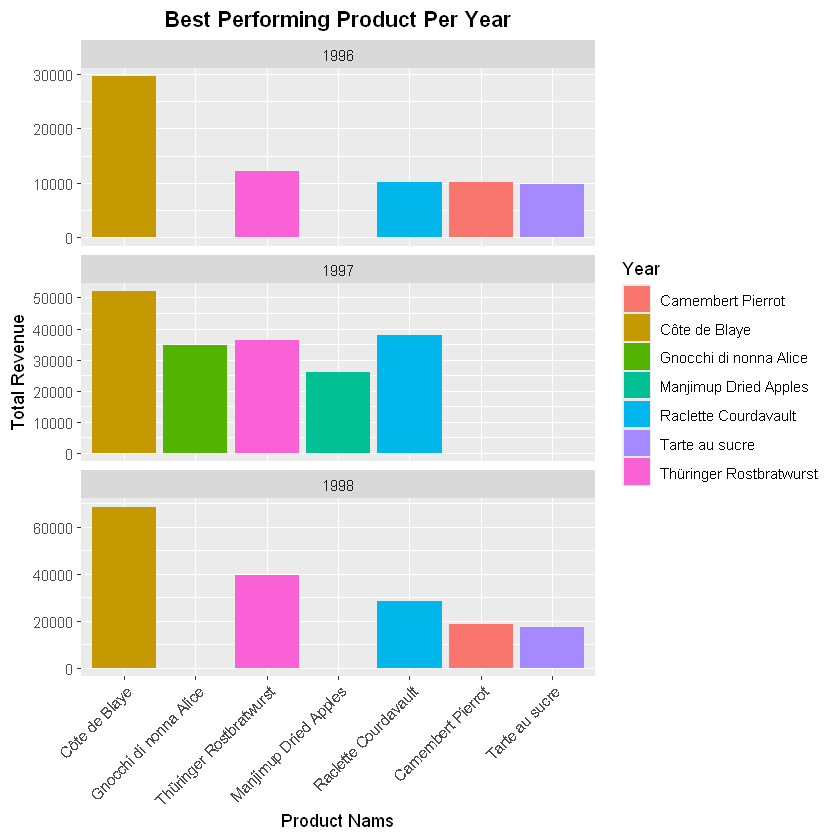

In [ ]:
# prints barplot visualization for seasonal trends by products per year 
ggplot(best_prod_year, aes(x = reorder(product_name, -total_revenue), y = total_revenue, fill = factor(year))) +
  geom_col(aes(fill = product_name)) + 
  facet_wrap(~ year, scales = "free_y", ncol = 1) + 
  labs(
    title = "Best Performing Product Per Year",
    x = "Product Nams",
    y = "Total Revenue",
    fill = "Year"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# 🛍️ What is the average order size, and how has it changed?

In [ ]:
# print average order size per year
avg_order_size_per_year <- df %>%
group_by(year)%>%
summarise(mean = round(mean(order_quantity, na.rm = TRUE), 2), .groups = 'drop_last')

avg_order_size_per_year

year,mean
<dbl>,<dbl>
1996,23.66
1997,24.07
1998,23.51


<ggproto object: Class CoordFlip, CoordCartesian, Coord, gg>
    aspect: function
    backtransform_range: function
    clip: on
    default: FALSE
    distance: function
    expand: TRUE
    is_free: function
    is_linear: function
    labels: function
    limits: list
    modify_scales: function
    range: function
    render_axis_h: function
    render_axis_v: function
    render_bg: function
    render_fg: function
    setup_data: function
    setup_layout: function
    setup_panel_guides: function
    setup_panel_params: function
    setup_params: function
    train_panel_guides: function
    transform: function
    super:  <ggproto object: Class CoordFlip, CoordCartesian, Coord, gg>

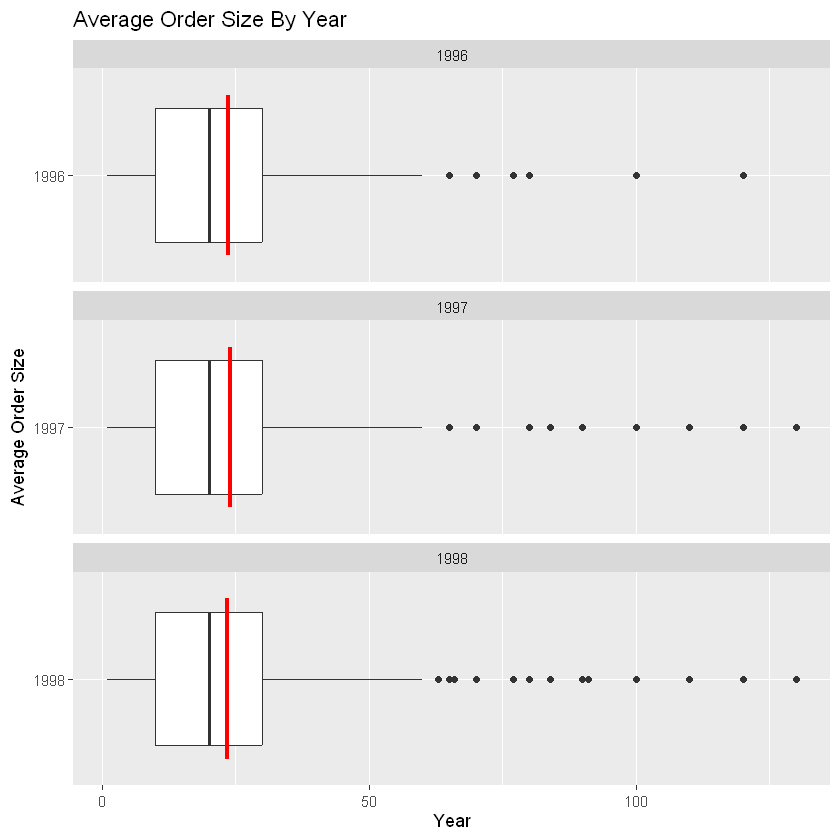

In [ ]:
# visualize average order size per year
ggplot(df, aes(y = factor(year), x = order_quantity)) +
geom_boxplot() +
stat_summary(fun = mean, geom = "crossbar", color = 'red') +
facet_wrap(~ factor(year), scales = "free_y", ncol = 1) + 
labs(
    title = 'Average Order Size By Year',
    x = 'Year',
    y = 'Average Order Size'
)
coord_flip()

In [ ]:
# printaverage order size per month
monthly_order_size <- df%>%
group_by(year, month)%>%
summarize(avg = round(mean(order_quantity, na.rm = TRUE), 2), .groups = 'drop_last')%>%
ungroup()%>%
arrange(year, desc(avg))

monthly_order_size



year,month,avg
<dbl>,<chr>,<dbl>
1996,December,27.16
1996,November,26.29
1996,July,24.78
1996,October,23.81
1996,September,19.72
1996,August,19.16
1997,January,28.25
1997,February,26.99
1997,July,26.68


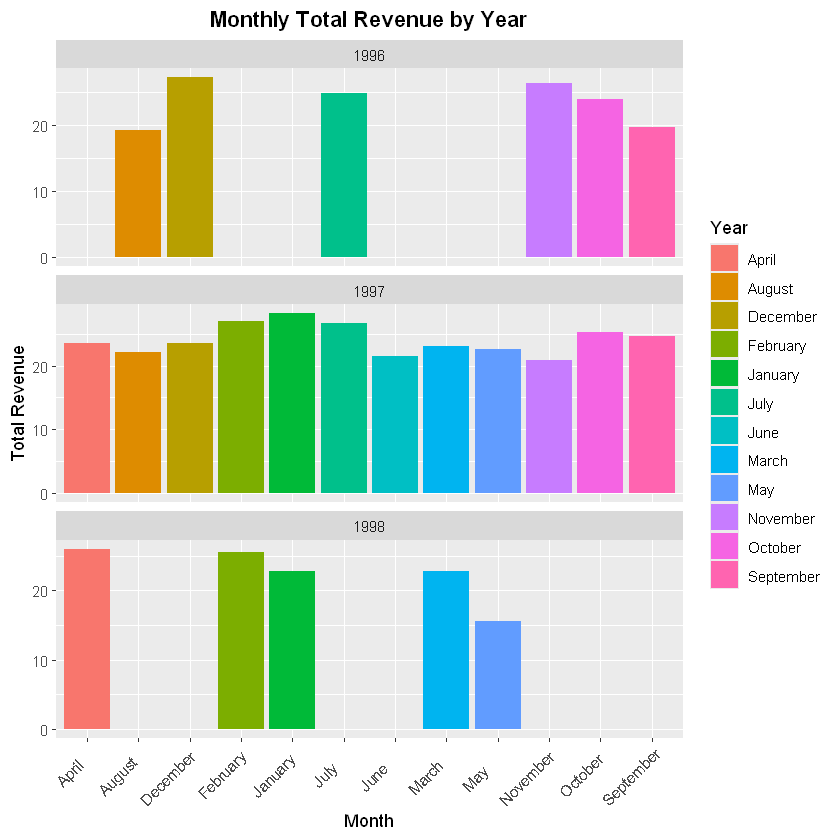

In [ ]:
#visualize average order size per year
ggplot(monthly_order_size, aes(x = month, y = avg, fill = factor(year))) +
  geom_col(aes(fill = month)) + 
  facet_wrap(~ year, scales = "free_y", ncol = 1) + 
  labs(
    title = "Monthly Total Revenue by Year",
    x = "Month",
    y = "Total Revenue",
    fill = "Year"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )